In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from classificatiom_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from classificatiom_model import evaluate_classification_model

# 解决中文显示问题
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

In [3]:
# 定义数据转换
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为PyTorch张量
    transforms.Normalize((0.286,), (0.353,))  # 标准化图像数据
])

# 加载Fashion MNIST数据集
train_dataset = datasets.FashionMNIST(
    root='./data',  # 数据存储路径
    train=True,  # 加载训练集
    download=True,  # 如果数据不存在则下载
    transform=transform  # 应用数据转换
)

test_dataset = datasets.FashionMNIST(
    root='./data',  # 数据存储路径
    train=False,  # 加载测试集
    download=True,  # 如果数据不存在则下载
    transform=transform  # 应用数据转换
)

# 获取图像和标签
# 注意：由于使用了transform，图像已经被转换为张量且标准化
# 我们需要从dataset中提取原始图像用于显示
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 定义类别名称
class_names = ['T-shirt/top', '裤子', '套头衫', '连衣裙', '外套',
               '凉鞋', '衬衫', '运动鞋', '包', '短靴']

# 查看数据集基本信息
print(f"训练集形状: {train_images.shape}")
print(f"训练集标签数量: {len(train_labels)}")
print(f"测试集形状: {test_images.shape}")
print(f"测试集标签数量: {len(test_labels)}")


训练集形状: (60000, 28, 28)
训练集标签数量: 60000
测试集形状: (10000, 28, 28)
测试集标签数量: 10000


In [4]:
# 划分训练集和验证集
from torch.utils.data import DataLoader, random_split

# 设置随机种子以确保可重复性
torch.manual_seed(42)

# 定义训练集和验证集的大小
train_size = 55000
val_size = 5000
assert train_size + val_size == len(train_dataset), "训练集和验证集大小总和必须等于原始训练集大小"

# 使用random_split函数划分数据集
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# 创建数据加载器
batch_size = 64
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_subset)}")
print(f"验证集大小: {len(val_subset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")


训练集大小: 55000
验证集大小: 5000
测试集大小: 10000
批次大小: 64
训练批次数: 860


In [6]:
# 实现深度可分离卷积层
import torch.nn as nn

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        # 深度卷积 - 每个输入通道使用单独的卷积核
        # 相比标准卷积，深度卷积将每个输入通道单独处理，减少参数量
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,  # 输入通道数
            out_channels=in_channels,  # 输出通道数等于输入通道数
            kernel_size=kernel_size,  # 卷积核大小
            padding=padding,  # 填充大小
            stride=stride,  # 步长
            groups=in_channels  # 设置groups等于输入通道数，实现深度卷积
        )
        # 逐点卷积 - 使用1x1卷积进行跨通道信息融合
        # 1x1卷积在空间维度上不进行操作，只在通道维度上进行线性组合
        self.pointwise = nn.Conv2d(
            in_channels=in_channels,  # 输入通道数
            out_channels=out_channels,  # 输出通道数
            kernel_size=1,  # 1x1卷积核
            stride=1,  # 步长为1
            padding=0  # 不需要填充
        )
    
    def forward(self, x):
        # 前向传播：先进行深度卷积，再进行逐点卷积
        x = self.depthwise(x)  # 应用深度卷积
        x = self.pointwise(x)  # 应用逐点卷积
        return x
        
# 创建一个输入张量，形状为[1, 3, 32, 32]，表示一个3通道的32x32图像
input_tensor = torch.randn(1, 3, 32, 32)

# 创建深度可分离卷积层实例
conv_standard = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
conv_depthwise = DepthwiseSeparableConv(in_channels=3, out_channels=16, kernel_size=3, padding=1)

# 应用两种卷积操作
output_standard = conv_standard(input_tensor)
output_depthwise = conv_depthwise(input_tensor)

# 打印输出形状
print(f"标准卷积输出形状: {output_standard.shape}")
print(f"深度可分离卷积输出形状: {output_depthwise.shape}")

# 比较参数量
params_standard = sum(p.numel() for p in conv_standard.parameters())
params_depthwise = sum(p.numel() for p in conv_depthwise.parameters())

print(f"标准卷积参数量: {params_standard}")
print(f"深度可分离卷积参数量: {params_depthwise}")
print(f"参数量减少: {params_standard / params_depthwise:.2f}倍")




标准卷积输出形状: torch.Size([1, 16, 32, 32])
深度可分离卷积输出形状: torch.Size([1, 16, 32, 32])
标准卷积参数量: 448
深度可分离卷积参数量: 94
参数量减少: 4.77倍


In [8]:

import torch.nn as nn
import torch.nn.functional as F

# 定义CNN模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 第一层：两次卷积+一次池化
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 输入1通道(灰度图)，输出32通道，使用普通卷积
            DepthwiseSeparableConv(32, 32, kernel_size=3, padding=1),  # 32通道输入输出，使用深度可分离卷积
            nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2池化，步长为2，特征图尺寸减半(28x28->14x14)
        )
        
        # 第二层：两次卷积+一次池化
        self.conv2 = nn.Sequential(
            DepthwiseSeparableConv(32, 64, kernel_size=3, padding=1),  # 32通道输入，64通道输出，使用深度可分离卷积
            DepthwiseSeparableConv(64, 64, kernel_size=3, padding=1),  # 64通道输入输出，使用深度可分离卷积
            nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2池化，步长为2，特征图尺寸减半(14x14->7x7)
        )
        
        # 第三层：两次卷积+一次池化
        self.conv3 = nn.Sequential(
            DepthwiseSeparableConv(64, 128, kernel_size=3, padding=1),  # 64通道输入，128通道输出，使用深度可分离卷积
            DepthwiseSeparableConv(128, 128, kernel_size=3, padding=1),  # 128通道输入输出，使用深度可分离卷积
            nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2池化，步长为2，特征图尺寸减半(7x7->3x3)
        )
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.Flatten(),  # 展平操作，将三维特征图转为一维向量
            nn.Linear(128 * 3 * 3, 512),  # 全连接层，输入维度是特征图大小，输出512个神经元
            nn.Dropout(0.5),  # 随机丢弃50%的神经元，防止过拟合
            nn.Linear(512, 10)  # 最终输出层，10个类别对应MNIST的10个数字
        )
        
    def forward(self, x):
        # 前向传播过程
        x = self.conv1(x)  # 第一层卷积+池化
        x = self.conv2(x)  # 第二层卷积+池化
        x = self.conv3(x)  # 第三层卷积+池化
        x = self.fc(x)     # 全连接层分类  
        return x

# 创建模型实例
model = CNN()
print(model)  # 打印模型结构

# 将模型移至GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"使用设备: {device}")

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于分类问题
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam优化器，学习率0.001

# 创建早停对象，修复delta类型为整数
early_stopping = EarlyStopping(patience=5, delta=0)  # 当验证集性能5轮不提升时停止训练


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): DepthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (pointwise): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): DepthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 6

In [10]:

# 实例化模型
model = CNN()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)

    

批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])


In [11]:
from torch.utils.tensorboard import SummaryWriter
class TensorboardLogger:
    """
    Tensorboard日志记录类：记录训练过程中的损失和准确率
    
    参数:
        log_dir: 日志保存目录,log_dir的父目录不要有中文
    """
    def __init__(self, log_dir='tensorboard_logs'):

        import os
        
        # 确保日志目录存在
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
            
        self.writer = SummaryWriter(log_dir) # 实例化SummaryWriter, log_dir是log存放路径，flush_secs是每隔多少秒写入磁盘
        
    def log_training(self, epoch, train_loss, train_acc):
        """
        记录训练数据
        
        参数:
            epoch: 当前训练轮数
            train_loss: 训练损失
            train_acc: 训练准确率
        """
        self.writer.add_scalar('训练/损失', train_loss, epoch)
        self.writer.add_scalar('训练/准确率', train_acc, epoch)
        
    def log_validation(self, epoch, val_loss, val_acc):
        """
        记录验证数据
        
        参数:
            epoch: 当前训练轮数
            val_loss: 验证损失
            val_acc: 验证准确率
        """
        self.writer.add_scalar('验证/损失', val_loss, epoch)
        self.writer.add_scalar('验证/准确率', val_acc, epoch)
    
    def log_lr(self, epoch, lr):
        """
        记录学习率
        
        参数:
            epoch: 当前训练轮数
            lr: 学习率
        """
        self.writer.add_scalar('学习率', lr, epoch)
        
    def log_model_graph(self, model, images):
        """
        记录模型结构图
        
        参数:
            model: 模型
            images: 输入图像样本
        """
        self.writer.add_graph(model, images)
        
    def close(self):
        """
        关闭Tensorboard写入器
        """
        self.writer.close()

In [12]:
model = CNN()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
# 用少量样本就能更新权重，训练更快，且更容易跳出局部最优
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

print("损失函数:", loss_fn)
print("优化器:", optimizer)

损失函数: CrossEntropyLoss()
优化器: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)
tensorboard_logger=TensorboardLogger(log_dir='logs')

model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=tensorboard_logger)


使用设备: cuda:0


Training Progress:   0%|          | 0/43000 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: 90.3400
早停: 已有5轮验证损失没有改善！


In [14]:
# 导入绘图库
import matplotlib.pyplot as plt
from matplotlib import font_manager
def plot_learning_curves1(history):
    # 设置中文字体支持
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

    # 创建一个图形，包含两个子图（损失和准确率）
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制损失曲线
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='训练损失')
    ax1.plot(epochs, history['val_loss'], 'r-', label='验证损失')
    ax1.set_title('训练与验证损失')
    ax1.set_xlabel('轮次')
    ax1.set_ylabel('损失')
    ax1.legend()
    ax1.grid(True)

    # 绘制准确率曲线
    ax2.plot(epochs, history['train_acc'], 'b-', label='训练准确率')
    ax2.plot(epochs, history['val_acc'], 'r-', label='验证准确率')
    ax2.set_title('训练与验证准确率')
    ax2.set_xlabel('轮次')
    ax2.set_ylabel('准确率 (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

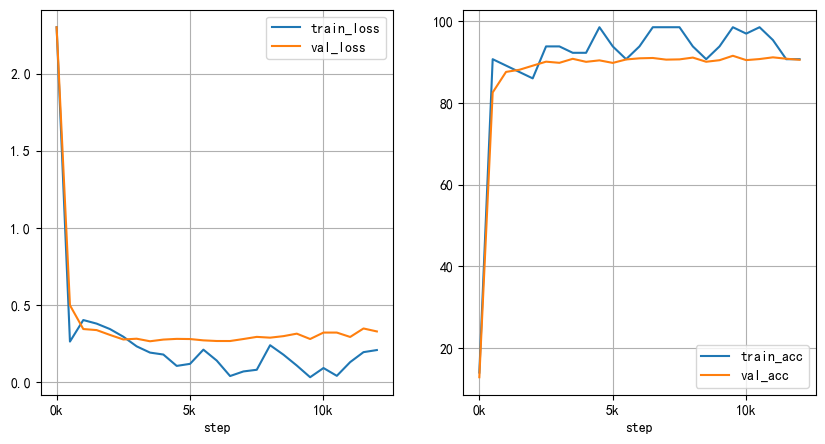

In [10]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [15]:
# 在测试集上评估模型
test_accuracy = evaluate_classification_model(model, test_loader, device, loss_fn)
test_accuracy


(88.7, 0.32716857492923734)